In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import importlib.util
import warnings; warnings.simplefilter('ignore')
%reload_ext rpy2.ipython

In [2]:
data_dir = os.environ['DATA_DIR']
img_dir = os.environ['IMG_DIR']
nb_dir = os.path.join(os.path.split(data_dir)[0], 'notebooks')

spec = importlib.util.spec_from_file_location("ActivityLearner", os.path.join(nb_dir, "neural_net.py"))
ann = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ann)

In [3]:
strains_fp = os.path.join(data_dir, 'isolates.tsv')
bgc_pa_file = os.path.join(data_dir, 'bgc_presence_absence.tsv')
pe_features_fp = os.path.join(data_dir, 'prioritization_exp_features.tsv')
supplemental_os_fig_fp = os.path.join(img_dir, 'supplemental_oversampling_effect_on_model_performance.png')
sa_rf_pickle_fp = os.path.join(data_dir, 'sa_rf_model_pickle')
sa_nn_pickle_fp = os.path.join(data_dir, 'sa_nn_model_pickle')
bs_rf_pickle_fp = os.path.join(data_dir, 'bs_rf_model_pickle')
bs_nn_pickle_fp = os.path.join(data_dir, 'bs_nn_model_pickle')

In [4]:
strains_df = pd.read_csv(strains_fp, sep='\t')
strains_df.head(3)

,strain_id,selection_tool,sample_type,country,state,phylum,class,order,family,genus,...,sa_confirmed_activity,sa_purity_test,sa_purity_confirmed,bs_primary_test,bs_confirmation_test,bs_confirmed_activity,bs_purity_test,bs_purity_confirmed,sa_ml_disease_ctrl,bs_ml_disease_ctrl
0,AFS000005,genome_similarity,Soil,Uganda,Amuria,Firmicutes,Bacilli,Bacillales,Bacillaceae_H,Bacillus_C,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,AFS000006,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,0,0,0,1.0,0.0,0.0,0.0,0.0,NaN,35.0
2,AFS000009,genome_similarity,Soil,United States,Texas,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas_E,...,1,1,1,1.0,1.0,1.0,1.0,1.0,NaN,80.0


In [5]:
pe_features_df = pd.read_csv(pe_features_fp, sep='\t')
pe_features_df.head(3)

,fam_cluster_id,feature_source
0,nrps4795,enrichment
1,nrps9044,random_forest
2,ripps2548,random_forest


In [6]:
bgc_pa_df = pd.read_csv(bgc_pa_file, sep='\t', index_col=0)
bgc_pa_df.head(3)

,AFS093623,AFS017508,AFS027748,AFS033376,AFS004652,AFS051571,AFS076057,AFS039214,AFS078944,AFS091220,...,AFS096509,AFS056026,AFS034936,AFS066035,AFS068876,AFS014772,AFS095483,AFS059847,AFS059137,AFS026130
fam_cluster_id,,,,,,,,,,,,,,,,,,,,,
nrps10000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nrps10007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
nrps10030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
training_strains = strains_df[(strains_df.selection_tool.isin(['diversity', 'spectrum', 'genome_similarity'])) &
                              (strains_df.strain_id.isin(bgc_pa_df.columns.tolist()))
                             ]

sa_training_strains = training_strains.query('sa_primary_test == 1')
bs_training_strains = training_strains.query('bs_primary_test == 1')

sa_active_strains = training_strains.query('sa_confirmation_test == 1')
bs_active_strains = training_strains.query('bs_confirmation_test == 1')

print(sa_training_strains.shape[0], sa_active_strains.shape[0])
print(bs_training_strains.shape[0], bs_active_strains.shape[0])

1051 93
559 52


In [8]:
bgc_pa_T = bgc_pa_df.T
bgc_pa_T.index.name = 'strain_id'
bgc_pa_T = bgc_pa_T[pe_features_df.fam_cluster_id.tolist()]

sa_bgc_pa_T = bgc_pa_T.loc[sa_training_strains.strain_id]
bs_bgc_pa_T = bgc_pa_T.loc[bs_training_strains.strain_id]

sa_bgc_pa_T['activity'] = sa_bgc_pa_T.apply(lambda row: row.name in sa_active_strains.strain_id.tolist(), axis=1)
bs_bgc_pa_T['activity'] = bs_bgc_pa_T.apply(lambda row: row.name in bs_active_strains.strain_id.tolist(), axis=1)

sa_bgc_features = sa_bgc_pa_T.drop(['activity'], axis=1)
bs_bgc_features = bs_bgc_pa_T.drop(['activity'], axis=1)

sa_bgc_activity = sa_bgc_pa_T[['activity']]
bs_bgc_activity = bs_bgc_pa_T[['activity']]
print(sa_bgc_features.shape, sa_bgc_activity.shape, bs_bgc_features.shape, bs_bgc_activity.shape)

(1051, 32) (1051, 1) (559, 32) (559, 1)


### Determine degree of oversampling that will optimize model recall 

We want higher recall so that we can find diverse active strains outside the taxonomic groups of the training set.

In [9]:
# Split into training/test, then oversample training set and evaluate resulting 
# model performance on non-oversampled test set.
# Repeat for cross validation.
oversample_scores = {'osf':[], 'f1':[], 'p':[], 'r':[]}
for osf in range(1, 18, 2):
    for i in range(100):
        x_train, x_test, y_train, y_test = train_test_split(sa_bgc_features, 
                                                            sa_bgc_activity, 
                                                            test_size=0.25, 
                                                            random_state=200519+i)
        
        tmp_actives = x_train[y_train.activity]
        tmp_actives_oversampled = [tmp_actives] * osf
        tmp_os_x = pd.concat([x_train] + tmp_actives_oversampled)
        tmp_new_ys = pd.DataFrame([True]*(tmp_actives.shape[0] * osf),
                                  columns=['activity'])
        tmp_os_y = pd.concat([y_train, tmp_new_ys])
        tmp_os_y.index = tmp_os_x.index

        tmp_rf = RandomForestClassifier(n_estimators=5, 
                                        max_depth=32,
                                        random_state=8180+i)
        
        tmp_rf.fit(tmp_os_x, tmp_os_y)
        tmp_y_pred = tmp_rf.predict(x_test)
        r = recall_score(y_pred=tmp_y_pred, y_true=y_test)
        p = precision_score(y_pred=tmp_y_pred, y_true=y_test)
        f1 = f1_score(y_pred=tmp_y_pred, y_true=y_test)
        oversample_scores['osf'].append(osf)
        oversample_scores['f1'].append(f1)
        oversample_scores['p'].append(p)
        oversample_scores['r'].append(r)
    
oversample_scores_df = pd.DataFrame(oversample_scores)

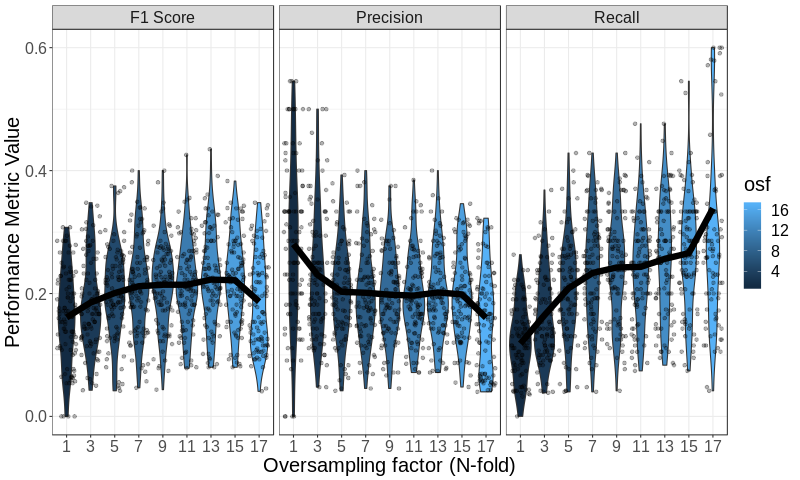

In [10]:
%%R -i oversample_scores_df -w 800
library(tidyverse)

long = oversample_scores_df %>%
    gather('metric', 'value', f1, p, r)

long$metric = factor(long$metric)
levels(long$metric) = c('F1 Score', 'Precision', 'Recall')

trend = long %>%
    group_by(osf, metric) %>%
    summarize(value=mean(value))

ggplot(long, aes(x=factor(osf), y=value)) +
    geom_violin(aes(fill=osf)) +
    geom_jitter(alpha=0.3) +
    geom_line(data=trend, size=3, aes(group=metric)) +
    labs(x='Oversampling factor (N-fold)',
         y='Performance Metric Value') +
    theme_bw() +
    ylim(0,0.6) +
    facet_wrap(~metric) + 
    theme(text = element_text(size=20))

Oversampling factor of 13 seems to work best (maximized mean F1 score). More than that and precision suffers.

In [11]:
%%R -i supplemental_os_fig_fp

ggsave(supplemental_os_fig_fp, height=4, width=6)

### Train RF models for Sorghum anthracnose and Black Sigatoka

In [12]:
osf = 13
sa_actives = sa_bgc_features[sa_bgc_activity.activity]
sa_actives_oversampled = [sa_actives] * 13
sa_os_x = pd.concat([sa_bgc_features] + sa_actives_oversampled)

sa_new_ys = pd.DataFrame([True]*(sa_actives.shape[0] * 13),
                          columns=['activity'])
sa_os_y = pd.concat([sa_bgc_activity, sa_new_ys])
sa_os_y.index = sa_os_x.index

sa_rf = RandomForestClassifier(n_estimators=5, 
                               max_depth=32,
                               random_state=22943)
sa_rf.fit(sa_os_x, sa_os_y)

RandomForestClassifier(max_depth=32, n_estimators=5, random_state=22943)

In [13]:
with open(sa_rf_pickle_fp, 'wb') as mf:
    pickle.dump(sa_rf, mf)

In [14]:
bs_actives = bs_bgc_features[bs_bgc_activity.activity]
bs_actives_oversampled = [bs_actives] * osf
bs_os_x = pd.concat([bs_bgc_features] + bs_actives_oversampled)

bs_new_ys = pd.DataFrame([True]*(bs_actives.shape[0] * osf),
                          columns=['activity'])
bs_os_y = pd.concat([bs_bgc_activity, bs_new_ys])
bs_os_y.index = bs_os_x.index

bs_rf = RandomForestClassifier(n_estimators=5, 
                               max_depth=32,
                               random_state=22943)

bs_rf.fit(bs_os_x, bs_os_y)

RandomForestClassifier(max_depth=32, n_estimators=5, random_state=22943)

In [15]:
with open(bs_rf_pickle_fp, 'wb') as mf:
    pickle.dump(bs_rf, mf)

### Train NN models for Sorghum anthracnose and Black Sigatoka

In [16]:
sa_nn = ann.ActivityLearner(n_features=bgc_pa_T.shape[1])
sa_nn.model.fit(sa_bgc_features.values.astype(np.float32), sa_bgc_activity.values.astype(np.float32))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ActivityNN(
    (dense1): Linear(in_features=32, out_features=10, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (dense2): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

In [17]:
sa_nn.model.save_params(f_params=sa_nn_pickle_fp)

In [18]:
bs_nn = ann.ActivityLearner(n_features=bgc_pa_T.shape[1])
bs_nn.model.fit(bs_bgc_features.values.astype(np.float32), bs_bgc_activity.values.astype(np.float32))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=ActivityNN(
    (dense1): Linear(in_features=32, out_features=10, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
    (dense2): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  ),
)

In [19]:
bs_nn.model.save_params(f_params=bs_nn_pickle_fp)